## Convert MP3 to Wav, Denoise, Apply SpeechBrain

In [2]:
from os import path
from pydub import AudioSegment

# files                                                                         
src = "converted_e29i0_ShanIndaAMAccent_enhanced.mp3"
dst = "converted_e29i0_ShanIndaAMAccent_enhanced.wav"

# convert wav to mp3                                                            
sound = AudioSegment.from_mp3(src)
sound.export(dst, format="wav")

<_io.BufferedRandom name='converted_e29i0_ShanIndaAMAccent_enhanced.wav'>

## 1- Voice Activity Detection with a (small) CRDNN model trained on Libriparty(HuggingFace)

### For the audio files that has different sampling rate, need to resample

In [5]:
import scipy.signal
import soundfile as sf

# Load the original audio file
audio, original_sample_rate = sf.read("converted_e29i0_ShanIndaAMAccent_enhanced.wav")

# Set the target sample rate
target_sample_rate = 16000

# Calculate the resampling ratio
resampling_ratio = target_sample_rate / original_sample_rate

# Resample the audio to the target sample rate
resampled_audio = scipy.signal.resample(audio, int(len(audio) * resampling_ratio))

# Save the resampled audio to a new file
sf.write("converted_e29i0_ShanIndaAMAccent_enhanced_resampled.wav", resampled_audio, target_sample_rate)

## Check channels and combine

In [11]:
import scipy.io.wavfile as wf
import numpy as np

filename = 'converted_e29i0_ShanIndaAMAccent_enhanced_resampled.wav'
rate = 0
def _read_wav(wav_file):
    rate, data = wf.read(wav_file)
    
    channels = len(data.shape)
    filename = wav_file

    # Convert to mono
    if channels == 2:
        print('Stereo')
        data = np.mean(data, axis=1, dtype=np.float32)
        channels = 1
    return rate, data

rate, data = _read_wav(filename)

Stereo


In [7]:
from pydub import AudioSegment
sound = AudioSegment.from_wav("converted_e29i0_ShanIndaAMAccent_enhanced_resampled.wav")
sound = sound.set_channels(1)
sound.export("converted_e29i0_ShanIndaAMAccent_enhanced_resampled_mono.wav", format="wav")

<_io.BufferedRandom name='converted_e29i0_ShanIndaAMAccent_enhanced_resampled_mono.wav'>

In [13]:
from speechbrain.pretrained import VAD

VAD = VAD.from_hparams(source="speechbrain/vad-crdnn-libriparty", savedir="pretrained_models/vad-crdnn-libriparty")
# boundaries = VAD.get_speech_segments("data/mywav_reduced_noise.wav")
boundaries = VAD.get_speech_segments("converted_e29i0_ShanIndaAMAccent_enhanced_resampled_mono.wav")
# Print the output
VAD.save_boundaries(boundaries)


segment_001  0.00  137.13 SPEECH


In [9]:
from speechbrain.pretrained import VAD
VAD = VAD.from_hparams(source="speechbrain/vad-crdnn-libriparty", savedir="pretrained_models/vad-crdnn-libriparty")

# 1- Let's compute frame-level posteriors first
audio_file = 'converted_e29i0_ShanIndaAMAccent_enhanced_resampled_mono.wav'
# audio_file = 'wav-sample.wav'
prob_chunks = VAD.get_speech_prob_file(audio_file)

# 2- Let's apply a threshold on top of the posteriors
prob_th = VAD.apply_threshold(prob_chunks).float()

# 3- Let's now derive the candidate speech segments
boundaries = VAD.get_boundaries(prob_th)

# 4- Apply energy VAD within each candidate speech segment (optional)

boundaries = VAD.energy_VAD(audio_file,boundaries)

# 5- Merge segments that are too close
boundaries = VAD.merge_close_segments(boundaries, close_th=0.250)

# 6- Remove segments that are too short
boundaries = VAD.remove_short_segments(boundaries, len_th=0.250)

# 7- Double-check speech segments (optional).
boundaries = VAD.double_check_speech_segments(boundaries, audio_file,  speech_th=0.5)
print(boundaries)

d:\soud\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The torchaudio backend is switched to 'soundfile'. Note that 'sox_io' is not supported on Windows.
torchvision is not available - cannot save figures
The torchaudio backend is switched to 'soundfile'. Note that 'sox_io' is not supported on Windows.
d:\soud\venv\lib\site-packages\torch\functional.py:641: UserWarning: stft with return_complex=False is deprecated. In a future pytorch release, stft will return complex tensors for all inputs, and return_complex=False will raise an error.
Note: you can still call torch.view_as_real on the complex output to recover the old return format. (Triggered internally at ..\aten\src\ATen\native\SpectralOps.cpp:867.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]


tensor([[  0.5400,   1.9800],
        [  2.4300,   5.9500],
        [  6.3500,  11.0000],
        [ 11.8200,  17.4800],
        [ 17.7800,  18.6000],
        [ 18.8700,  20.9900],
        [ 21.8700,  27.9700],
        [ 28.5800,  29.8500],
        [ 30.3500,  31.6600],
        [ 32.8000,  35.8500],
        [ 36.3900,  40.9200],
        [ 41.6600,  43.1600],
        [ 43.4900,  44.2000],
        [ 44.4600,  46.0700],
        [ 46.4300,  49.0900],
        [ 49.8200,  51.3700],
        [ 51.6700,  53.6600],
        [ 54.5100,  57.0600],
        [ 57.3300,  59.5500],
        [ 59.8700,  60.4800],
        [ 60.8300,  61.5900],
        [ 61.9700,  62.8600],
        [ 63.3300,  67.1500],
        [ 68.0900,  69.4600],
        [ 69.7500,  72.2600],
        [ 72.6000,  75.5700],
        [ 75.8500,  77.7200],
        [ 78.1500,  78.8800],
        [ 79.4300,  80.8200],
        [ 81.8800,  82.6900],
        [ 82.9500,  84.1600],
        [ 84.8000,  87.4900],
        [ 87.9500,  88.7700],
        [ 

## 2 - SILERO VOICE ACTIVITY DETECTOR

In [11]:
import torch
torch.set_num_threads(1)

from IPython.display import Audio
from pprint import pprint
# download example
torch.hub.download_url_to_file('https://models.silero.ai/vad_models/en.wav', 'en_example.wav')

model, utils = torch.hub.load(repo_or_dir='snakers4/silero-vad',
                              model='silero_vad',
                              force_reload=True)

(get_speech_timestamps,
 _, read_audio,
 *_) = utils

sampling_rate = 16000 # also accepts 8000
wav = read_audio('converted_e29i0_ShanIndaAMAccent_enhanced_resampled_mono.wav', sampling_rate=sampling_rate)
# get speech timestamps from full audio file


100%|██████████| 1.83M/1.83M [00:02<00:00, 743kB/s] 
Downloading: "https://github.com/snakers4/silero-vad/zipball/master" to C:\Users\Administrator/.cache\torch\hub\master.zip


[{'end': 2.0, 'start': 0.5},
 {'end': 3.7, 'start': 2.4},
 {'end': 6.0, 'start': 3.8},
 {'end': 8.0, 'start': 6.3},
 {'end': 9.3, 'start': 8.1},
 {'end': 11.0, 'start': 9.4},
 {'end': 14.0, 'start': 11.9},
 {'end': 17.5, 'start': 14.2},
 {'end': 18.6, 'start': 17.8},
 {'end': 19.7, 'start': 18.7},
 {'end': 21.0, 'start': 20.0},
 {'end': 23.8, 'start': 21.8},
 {'end': 26.8, 'start': 23.9},
 {'end': 28.0, 'start': 26.9},
 {'end': 29.9, 'start': 28.5},
 {'end': 31.8, 'start': 30.3},
 {'end': 35.9, 'start': 32.8},
 {'end': 38.0, 'start': 36.4},
 {'end': 40.9, 'start': 38.1},
 {'end': 43.2, 'start': 41.6},
 {'end': 46.1, 'start': 43.5},
 {'end': 49.1, 'start': 46.4},
 {'end': 51.4, 'start': 49.8},
 {'end': 52.5, 'start': 51.6},
 {'end': 53.7, 'start': 52.7},
 {'end': 57.1, 'start': 54.5},
 {'end': 58.0, 'start': 57.3},
 {'end': 59.5, 'start': 58.1},
 {'end': 60.5, 'start': 60.0},
 {'end': 61.7, 'start': 60.8},
 {'end': 62.9, 'start': 62.0},
 {'end': 67.2, 'start': 63.3},
 {'end': 69.5, 'sta

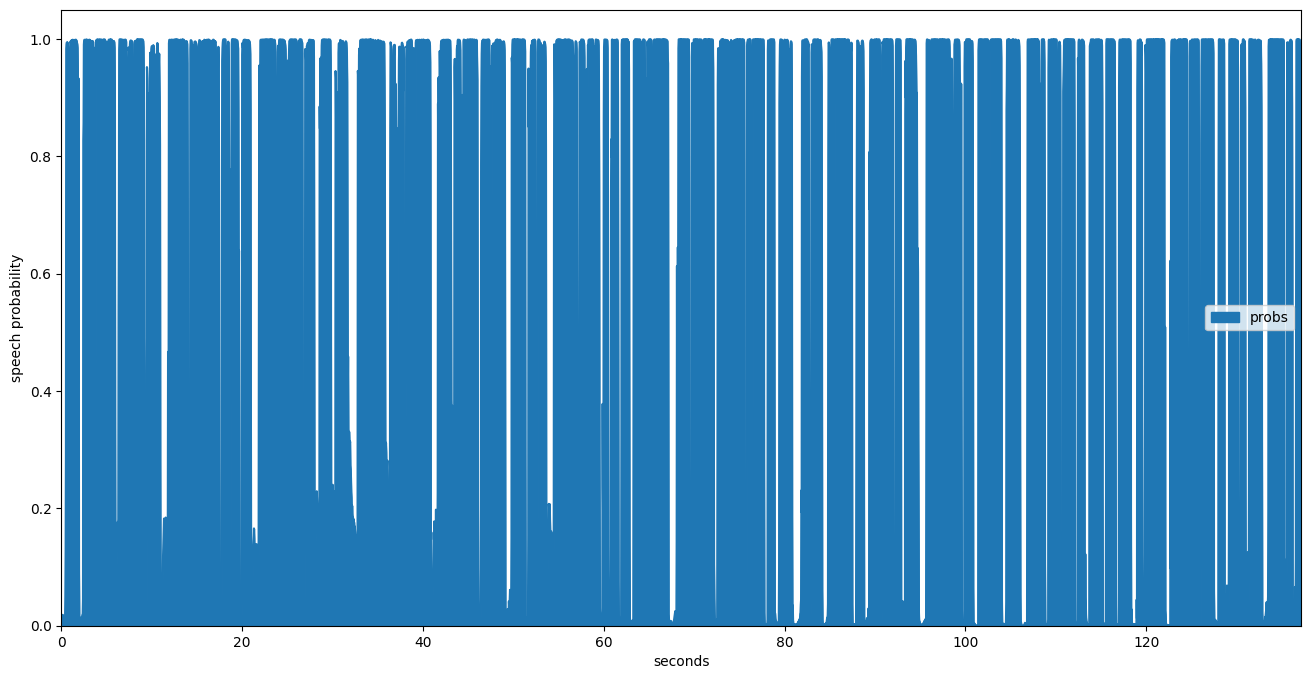

In [13]:
speech_timestamps = get_speech_timestamps(wav, model, sampling_rate=sampling_rate, visualize_probs=True, return_seconds=True)
pprint(speech_timestamps)

In [14]:
import json

[{'start': 0.5, 'end': 2.0, 'duration': '1.5'}, {'start': 2.4, 'end': 3.7, 'duration': '1.3000000000000003'}, {'start': 3.8, 'end': 6.0, 'duration': '2.2'}, {'start': 6.3, 'end': 8.0, 'duration': '1.7000000000000002'}, {'start': 8.1, 'end': 9.3, 'duration': '1.200000000000001'}, {'start': 9.4, 'end': 11.0, 'duration': '1.5999999999999996'}, {'start': 11.9, 'end': 14.0, 'duration': '2.0999999999999996'}, {'start': 14.2, 'end': 17.5, 'duration': '3.3000000000000007'}, {'start': 17.8, 'end': 18.6, 'duration': '0.8000000000000007'}, {'start': 18.7, 'end': 19.7, 'duration': '1.0'}, {'start': 20.0, 'end': 21.0, 'duration': '1.0'}, {'start': 21.8, 'end': 23.8, 'duration': '2.0'}, {'start': 23.9, 'end': 26.8, 'duration': '2.900000000000002'}, {'start': 26.9, 'end': 28.0, 'duration': '1.1000000000000014'}, {'start': 28.5, 'end': 29.9, 'duration': '1.3999999999999986'}, {'start': 30.3, 'end': 31.8, 'duration': '1.5'}, {'start': 32.8, 'end': 35.9, 'duration': '3.1000000000000014'}, {'start': 36.4

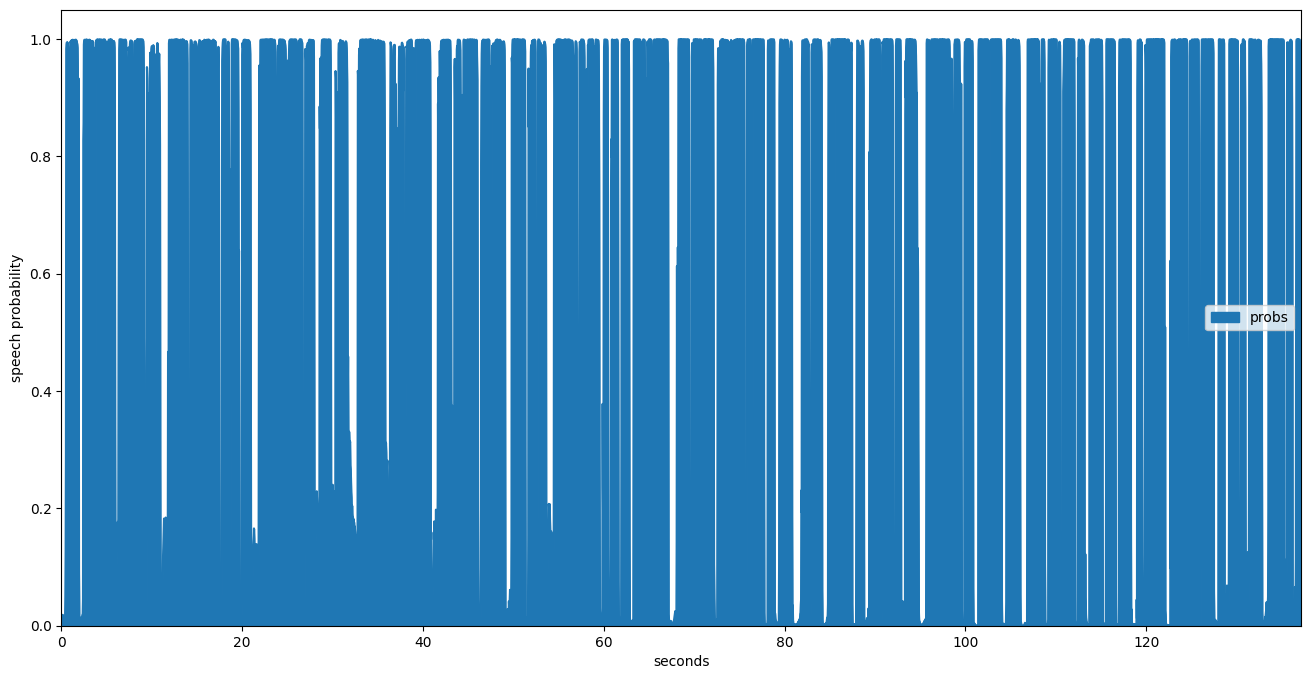

In [15]:
sampling_rate = 16000 # also accepts 8000
wav = read_audio('converted_e29i0_ShanIndaAMAccent_enhanced_resampled_mono.wav', sampling_rate=sampling_rate)
# get speech timestamps from full audio file
speech_timestamps = get_speech_timestamps(wav, model, sampling_rate=sampling_rate, visualize_probs=True, return_seconds=True)
# pprint(speech_timestamps)

pause_data = []
for speech_timestamp in speech_timestamps:
    pause_data.append({'start': speech_timestamp['start'], 'end': speech_timestamp['end'], 'duration' : str( speech_timestamp['end'] - speech_timestamp['start'])})
  
print(pause_data)
json_data = json.dumps(pause_data)
with open('pause_json_data.json', 'w') as outfile:
    outfile.write(json_data)

## Test performance


In [ ]:
from speechbrain.pretrained import VAD
from sklearn.metrics import accuracy_score, recall_score
import os
import glob
import pathlib

# Load the pre-trained VAD model
vad_model = VAD.from_hparams(source="speechbrain/vad-crdnn-libriparty", savedir="pretrained_models/vad-crdnn-libriparty")





# Process the audio files and evaluate the model's performance
current_path = pathlib.Path().resolve()
test_dataset = "\\test_dataset\\LibriSpeecc\\test-clean"  # Path to your test dataset
ground_truth_annotations = "./test dataset/labels"  # Path to your ground truth annotations

test_path = os.path.join(current_path, test_dataset)

predictions = []
ground_truth = []


test_dataset = "\\test_dataset\\LibriSpeech\\test-clean"  # Path to your test dataset
ground_truth_annotations = "\\test_dataset\\labels"  # Path to your ground truth annotations

# test_path = os.path.join(current_path, test_dataset)
test_path = os.getcwd() + test_dataset
truth_annotation_path = os.getcwd() + ground_truth_annotations

print(truth_annotation_path)

def get_file_paths(root_dir):
    file_paths = []  # List to store file paths
    
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for filename in filenames:
            file_path = os.path.join(dirpath, filename)
            if(file_path.endswith('flac')):
                file_paths.append(file_path)
    
    return file_paths

def extract_speech_segments(boundaries):
    # Implement your own criteria for extracting speech segments from boundaries
    threshold_duration = 0.2
    speech_segments = []
    # print(len(boundaries))
    # print(boundaries[1])
    # print(boundaries[0][0], boundaries[0][1], boundaries[0][1] - boundaries[0][0] > threshold_duration)
    for i in range(len(boundaries) - 1):
        if boundaries[i][1] - boundaries[i][0] > threshold_duration:
            print(1)
            speech_segments.append(1)  # Speech segment
        else:
            print(0)
            speech_segments.append(0)  # Non-speech segment
    print(speech_segments)
    return speech_segments

def load_ground_truth_annotations(audio_file, annotations_dir):
    # Implement loading of ground truth annotations for the given audio file
    # The annotations could be stored in a file or any other format you prefer
    # Return a list of ground truth labels corresponding to speech or non-speech segments
    annotations_file = os.path.join(annotations_dir, os.path.basename(audio_file).replace(".flac", ".json"))
    with open(annotations_file, 'r') as file:
        annotations = [int(line.strip()) for line in file]
    return annotations

all_file_paths = get_file_paths(test_path)

# Iterate over the audio files in the test dataset
for audio_file in all_file_paths:
    print(audio_file)
    # Apply the VAD model on the audio file
    boundaries = vad_model.get_speech_segments(audio_file)

    # Convert the boundaries to predictions (speech or non-speech)
    # based on your criteria (e.g., duration of the speech segment)
    speech_segments = extract_speech_segments(boundaries)  # Implement your own function
    # speech_segments = [1 if start <= i < end else 0 for start, end in boundaries for i in range(start, end)]


    # Load the corresponding ground truth annotations
    # gt_annotations = load_ground_truth_annotations(audio_file, truth_annotation_path)  # Implement your own function

    # Append the predictions and ground truth labels for evaluation
    predictions.extend(speech_segments)
    print(predictions)
    # ground_truth.extend(gt_annotations)


# Calculate evaluation metrics
accuracy = accuracy_score(ground_truth, predictions)
recall = recall_score(ground_truth, predictions)

# Print the evaluation results
print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")


In [ ]:
current_path = pathlib.Path().resolve()
print('current', current_path)


print()
predictions = []
ground_truth = []


def get_file_paths(root_dir):
    file_paths = []  # List to store file paths
    
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for filename in filenames:
            file_path = os.path.join(dirpath, filename)
            file_paths.append(file_path)
    
    return file_paths
print('test',test_path)
# Get all file paths in subfolders
all_file_paths = get_file_paths(test_path)

# Print the list of file paths
for file_path in all_file_paths:
    print(file_path)

In [ ]:
import soundfile as sf
import re
from speechbrain.pretrained import EncoderDecoderASR
from speechbrain.pretrained import VAD

# Load and preprocess the audio
audio_file = 'converted_e29i0_ShanIndaAMAccent_enhanced_resampled_mono.wav'  # Replace with your audio file
audio, sample_rate = sf.read(audio_file)


# Transcribe speech
asr_model = EncoderDecoderASR.from_hparams(source="speechbrain/asr-crdnn-rnnlm-librispeech", savedir="pretrained_models/asr-wav2vec2-commonvoice-en")
asr_model.transcribe_file("converted_e29i0_ShanIndaAMAccent_enhanced_resampled_mono.wav")

## Using pyAudioAnalysis

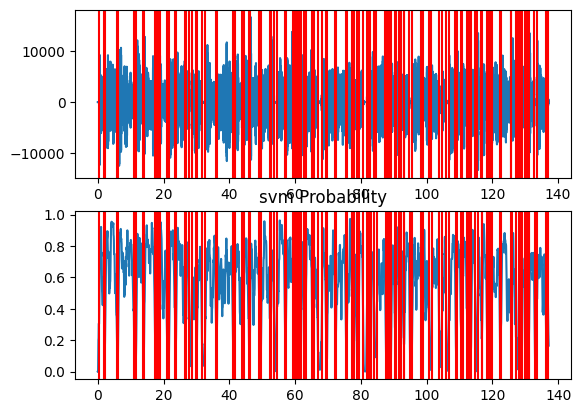

Speech detected from 300ms to 2000ms
Speech detected from 2300ms to 5750ms
Speech detected from 6250ms to 11000ms
Speech detected from 11750ms to 13800ms
Speech detected from 14150ms to 17350ms
Speech detected from 17700ms to 18300ms
Speech detected from 18800ms to 21000ms
Speech detected from 21800ms to 23500ms
Speech detected from 23850ms to 26650ms
Speech detected from 26850ms to 27850ms
Speech detected from 28550ms to 29900ms
Speech detected from 30250ms to 31600ms
Speech detected from 32700ms to 35900ms
Speech detected from 36250ms to 41000ms
Speech detected from 41650ms to 43950ms
Speech detected from 44400ms to 45900ms
Speech detected from 46300ms to 49150ms
Speech detected from 49700ms to 52400ms
Speech detected from 52600ms to 53700ms
Speech detected from 54450ms to 56900ms
Speech detected from 57250ms to 59500ms
Speech detected from 59900ms to 60500ms
Speech detected from 60900ms to 61350ms
Speech detected from 61900ms to 62800ms
Speech detected from 63200ms to 65150ms
Speech

In [3]:
import os
from pydub import AudioSegment
from pyAudioAnalysis import audioBasicIO, audioSegmentation
import json

def detect_sentence_boundaries(audio_file):
    # Load the audio file
    audio = AudioSegment.from_wav(audio_file)

    # Convert the audio to mono
    audio = audio.set_channels(1)

    # Export the audio as a temporary WAV file
    temp_file = "temp.wav"
    audio.export(temp_file, format="wav")

    # Read the audio using pyAudioAnalysis
    [fs, x] = audioBasicIO.read_audio_file(temp_file)

    # Apply VAD using pyAudioAnalysis
    segments = audioSegmentation.silence_removal(
        x,
        fs,
        0.05,  # Window size (in seconds)
        0.05,  # Window step (in seconds)
        smooth_window=0.5,
        weight=0.3,
        plot=True
    )

    # Convert segments to start and end times
    pause_threshold = 500
    sentence_segments = []
    is_speech = False
    segment_start = 0.0    

    speech_segments = []
    for segment in segments:
        start_time = int(segment[0] * 1000)
        end_time = int(segment[1] * 1000)
        speech_segments.append((start_time, end_time))

        if is_speech:
            segment_end = start_time
            segment_duration = segment_end - segment_start
            if segment_duration > pause_threshold:
                sentence_segments.append([segment_start, segment_end])
            is_speech = False
        else:
            segment_start = end_time
            is_speech = True
    
    sentence_segments = [[start, end] for start, end in sentence_segments]

    # Clean up the temporary file
    os.remove(temp_file)

    return speech_segments, sentence_segments

# Example usage
audio_file = 'converted_e29i0_ShanIndaAMAccent_enhanced_resampled_mono.wav'
speech_segments, sentence_segments = detect_sentence_boundaries(audio_file)

# Print the detected speech segments
pause_data = []
for segment in speech_segments:
    start_time = segment[0]
    end_time = segment[1]
    print(f"Speech detected from {start_time}ms to {end_time}ms")

    pause_data.append({'start': start_time, 'end': end_time, 'duration': end_time- start_time})

sentence_data = []
for segment in sentence_segments:
    start_time = segment[0]
    end_time = segment[1]    
    print(f"Sentence detected from {start_time}ms to {end_time}ms")

    sentence_data.append({'start': start_time, 'end': end_time, 'duration': end_time - start_time})

json_pause_data = json.dumps(pause_data)
with open('pause_json_data_audioanalysis.json', 'w') as outfile:
    outfile.write(json_pause_data)

json_sentence_data = json.dumps(sentence_data)
with open('sentence_json_data_audioanalysis.json', 'w') as outfile:
    outfile.write(json_sentence_data)





In [33]:
import webrtcvad
import librosa

def detect_pauses(audio_file, pause_duration_threshold=3.0, aggressiveness=3, frame_length=30, hop_length=10):
    # Load audio and apply VAD
    audio, sample_rate = librosa.load(audio_file, sr=None)
    vad = webrtcvad.Vad()
    vad.set_mode(aggressiveness)

    frames = librosa.util.frame(audio, frame_length=frame_length, hop_length=hop_length)
    speech_segments = []
    for frame in frames:        
        if vad.is_speech(frame.tobytes(), sample_rate):
            speech_segments.append(frame)
        

    # Detect pauses
    pause_segments = []
    prev_segment_end = 0.0
    for segment in speech_segments:
        segment_start = prev_segment_end
        segment_end = segment_start + len(segment) / sample_rate
        print(segment_start - prev_segment_end)
        if segment_start - prev_segment_end > pause_duration_threshold:
            pause_segments.append((prev_segment_end, segment_start))

        prev_segment_end = segment_end

    # Process the final pause (after the last speech segment)
    final_pause_start = prev_segment_end
    final_pause_end = len(audio) / sample_rate
    if final_pause_end - final_pause_start > pause_duration_threshold:
        pause_segments.append((final_pause_start, final_pause_end))

    return pause_segments

# Example usage
audio_file = 'converted_e29i0_ShanIndaAMAccent_enhanced_resampled_mono.wav'  # Replace with your audio file
pause_segments = detect_pauses(audio_file)

# Print pause segments
for i, (pause_start, pause_end) in enumerate(pause_segments):
    print(f"Pause {i + 1}: Start: {pause_start}, End: {pause_end}")


ModuleNotFoundError: No module named 'webrtcvad'